In [1]:
from pmotifs.analysis_utilities.loading import load_results
from pmotifs.config import config

g, df = load_results(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    3,
)

Loading Graphlet Metrics: 100%|█████████████████████████████████| 13150/13150 [00:00<00:00, 146732.02it/s]


In [2]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Node Choice

In [3]:
relevant_node = "205"

nx_g = g.load_graph()
assert relevant_node in nx_g.nodes, "No such node!"

# Analysis

In [4]:
relevant_motifs = df[df["nodes"].apply(lambda nodes: relevant_node in nodes)]
relevant_motifs.head()
relevant_motifs.shape

(33, 5)

([<matplotlib.patches.Wedge at 0x7fbc0200ba90>,
 [Text(-1.055442297353649, 0.30990572269135613, '3-Dash'),
  Text(1.0554423263691122, -0.30990562387371495, 'Triangle')],
 [Text(-0.5756957985565357, 0.16903948510437605, '30'),
  Text(0.5756958143831521, -0.1690394312038445, '3')])

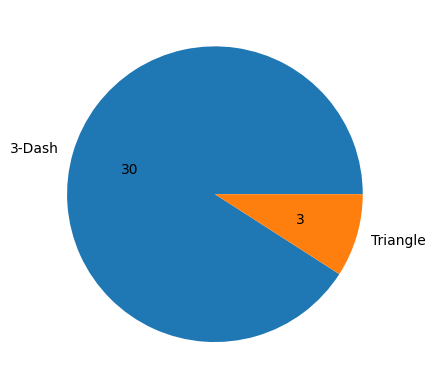

In [5]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name

grouped_by_class_df = relevant_motifs.groupby("graphlet_class").agg("count")
total = sum(grouped_by_class_df["nodes"])

plt.pie(
    list(grouped_by_class_df["nodes"]),
    labels=list(map(graphlet_class_to_name, grouped_by_class_df.index)),
    autopct=lambda p: int(total * p / 100),
)

In [6]:
METRIC_NAME = "degree"

In [7]:
"""Tukey Method"""
from scipy.stats import iqr
from scipy.stats.mstats import mquantiles

metrics = df[METRIC_NAME].astype(float)

q1, q2, q3 = mquantiles(metrics)
inner_quantile_range = iqr(metrics)

lower_outlier_cut = q1 - 1.5 * inner_quantile_range
upper_outlier_cut = q3 + 1.5 * inner_quantile_range

print(f"Outliers: x < {lower_outlier_cut}, {upper_outlier_cut} > x")

lower_outlier = 0
upper_outlier = 0
for relevant_motif_metric in relevant_motifs[METRIC_NAME]:
    
    if relevant_motif_metric < lower_outlier_cut:
        lower_outlier += 1
    if relevant_motif_metric > upper_outlier_cut:
        upper_outlier += 1

print(f"{lower_outlier}/{len(relevant_motifs)} motifs are lower outliers")
print(f"{upper_outlier}/{len(relevant_motifs)} motifs are upper outliers")

Outliers: x < -17.0, 95.0 > x
0/33 motifs are lower outliers
0/33 motifs are upper outliers


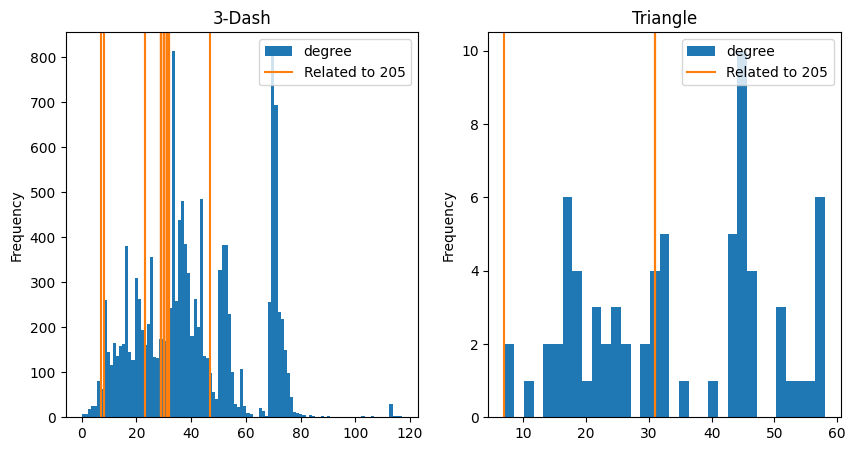

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pmotifs.graphlet_representation import graphlet_class_to_name


fig, axes = plt.subplots(1, len(grouped_by_class_df.index), figsize=(10,5))


for i, graphlet_class in enumerate(grouped_by_class_df.index):
    ax = axes[i]
    
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]
    
    bars = graphlet_class_df.plot.hist(bins=len(set(graphlet_class_df[METRIC_NAME])), ax=ax)

    relevant_motifs_for_class = relevant_motifs[
        relevant_motifs["graphlet_class"] == graphlet_class
    ]

    for relevant_motif_metric in relevant_motifs_for_class[METRIC_NAME]:
        ax.axvline(
            relevant_motif_metric,
            color="tab:orange",
        )
    ax.axvline(
        relevant_motif_metric,
        color="tab:orange",
        label=f"Related to {relevant_node}"
    )

    ax.legend()
    ax.set_title(graphlet_class_to_name(graphlet_class))

In [9]:
"""Prepare Graph Plotting"""
import networkx as nx

from pmotifs.analysis_utilities.plotting import prepare_kamada_kawai_layout_with_multiple_components

nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

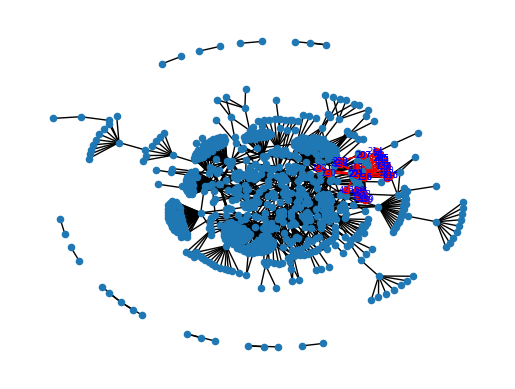

In [10]:
import matplotlib.pyplot as plt

from pmotifs.analysis_utilities.plotting import plot_graph_with_motif_highlight


fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(nx_g, [r_m for r_m in relevant_motifs["nodes"]], pos, ax)

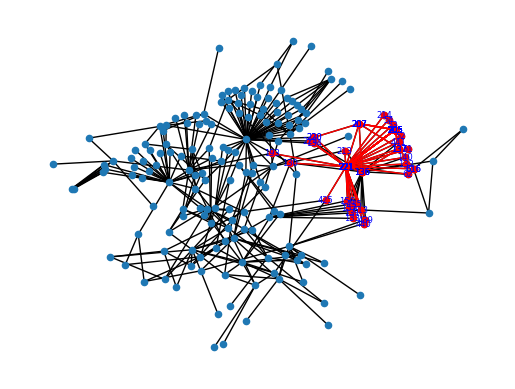

In [11]:
from pmotifs.analysis_utilities.plotting import get_zommed_graph, plot_graph_with_motif_highlight


fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(
    get_zommed_graph(nx_g, {n for r_m in relevant_motifs["nodes"] for n in r_m}),
    [r_m for r_m in relevant_motifs["nodes"]],
    pos,
    ax,
)